# Seminararbeit Benedikt Hollmann
# Generierung von Anime-Gesichtern mit Hilfe eines DCGAN
# Modul: Angewandte Programmierung
# Dozent: Philipp Koch

1. Bilder X und Y laden
2. Features von Bilder X lernen
3. Mit Modell Bilder Y zu X konvergieren lassen

In [11]:
#Systembibliotheken
import argparse #? Parsen von Modellen
import random #Randomnummern
import platform
from shutil import copyfile #Kopierfunktion
import os # OS Funktionen
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Fix für Intel MKL Fehler (doppeltes Laden der Math Library Kernel dll durch unterschiedliche Bibliotheken)

#Torch-Bibliotheken
import torch
import torchviz #Visualisierung der Modelle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torchsummary import summary #Textbeschreibung
#import torch.functional as F

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

#Sonstige Funktionen
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import PIL #Pillow für Bildinformationen
from PIL import Image #Pillow

if platform.system() == "Windows":
    print("GPU Torch Build für bessere Performance installieren!")
    os.system("pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio===0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html")
if platform.system() == "Darwin":
    print("Keine Cuda-Unterstützung bei MAC's")

fixed_random = 1337

Keine Cuda-Unterstützung bei MAC's
Package                            Version
---------------------------------- -------------------
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.9.1
anyio                              2.2.0
appdirs                            1.4.4
applaunchservices                  0.2.1
appnope                            0.1.2
appscript                          1.1.2
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.5
astropy                            4.2.1
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.6
Babel                              2.9.0
backcall                           0.2.0
backports.functools-lru-cache      1.6.4
backp

### Laden und Analyse der Bilddaten

In [2]:
# Definiere Ordnerpfad
dataroot = (f'Images')

dataroot_clean = (f'Images_Cleaned')

Laden der Trainingsdaten mittels ImageFolder-Funktion

In [3]:
dirty_dataset = dset.ImageFolder(root=dataroot)

In [5]:
dirty_dataset.targets = 0
#dirty_dataset.targets = 1
dirty_dataset

Dataset ImageFolder
    Number of datapoints: 63632
    Root location: Images

In [4]:
#Prüfe auf korrupte Daten
CorruptFiles = []
for idx in range(len(dirty_dataset)):
    try:
        batch = dirty_dataset[idx]
    except Exception as e:
        print(idx)
        CorruptFiles.append(idx)
        break #Early Stopping

973


In [12]:
copypath = os.path.dirname(os.path.abspath(dataroot))
copypath=copypath+"\Images_Cleaned"+"\\"+"Anime"+"\\"
copypath

if not os.path.exists(copypath):
    os.mkdir(copypath)

In [13]:
#Lösche alle Dateien welche 0kb groß sind #! Kopiere alle nicht cleanen Daten
corrupted_files = 0
for path, dirs, files in os.walk(dataroot):
    for f in files:
        fp = os.path.join(path, f)
        if (os.path.getsize(fp) == 0):
            corrupted_files+=1
            #os.remove(fp)
        else:
            copyfile(fp, copypath+f)
print("Es wurde erfolgreich eine bereinigte Kopie des Datensatzes unter dem Pfad {} erstellt".format(copypath))
print("Es wurden {} fehlerhafte Datein festgestellt".format(corrupted_files))

Es wurde erfolgreich eine bereinigte Kopie des Datensatzes erstellt
Es wurden 63 fehlerhafte Datein festgestellt


In [14]:
width = 0
height = 0
count = 0
px_merker = 0
max_px_w = 0
max_px_h = 0
min_px_w = 10000
min_px_h = 10000
widths = []
heights = []
for path, dirs, files in os.walk(copypath):
    for f in files:
        fp = os.path.join(path, f)
        img = PIL.Image.open(fp)
        wid, hgt = img.size
        px_merker = wid
        if px_merker<min_px_w:
            min_px_w = px_merker
        if px_merker>max_px_w:
            max_px_w = px_merker

        px_merker = hgt
        if px_merker<min_px_h:
            min_px_h = px_merker
        if px_merker>max_px_h:
            max_px_h = px_merker

        count +=1
        width+=wid
        height+=hgt
        widths.append(wid)
        heights.append(hgt)
print("Durchschnittliche Breite der Daten {}".format(width/count))
print("Durchschnittliche Höhe der Daten {}".format(height/count))
print("Minimale Breite {}".format(min_px_w))
print("Maximale Breite {}".format(max_px_w))
print("Minimale Höhe {}".format(min_px_h))
print("Maximale Höhe {}".format(max_px_h))

Durchschnittliche Breite der Daten 89.5927574761283
Durchschnittliche Höhe der Daten 89.5924900501817
Minimale Breite 25
Maximale Breite 220
Minimale Höhe 25
Maximale Höhe 220


In [15]:
(unique_w, counts_w) = np.unique(widths, return_counts=True)
(unique_h, counts_h) = np.unique(heights, return_counts=True)
frequencies_w = np.asarray((unique_w, counts_w)).T
frequencies_h = np.asarray((unique_h, counts_h)).T
#print(frequencies)

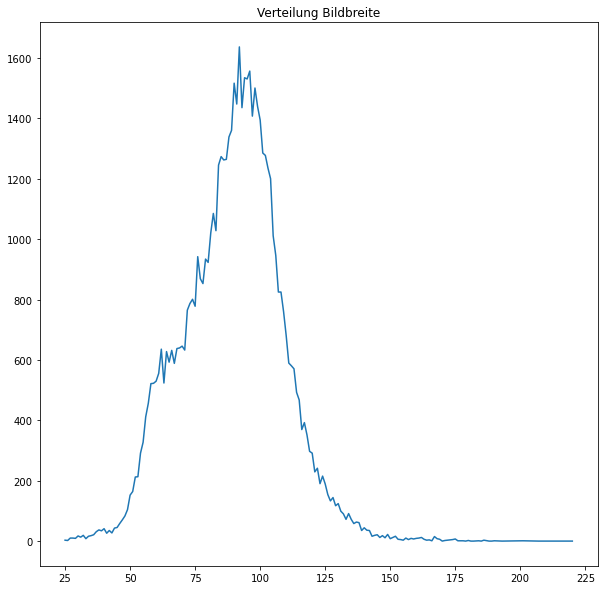

In [16]:
plt.figure(figsize=(10,10))
plt.title("Verteilung Bildbreite")
plt.plot(unique_w,counts_w)

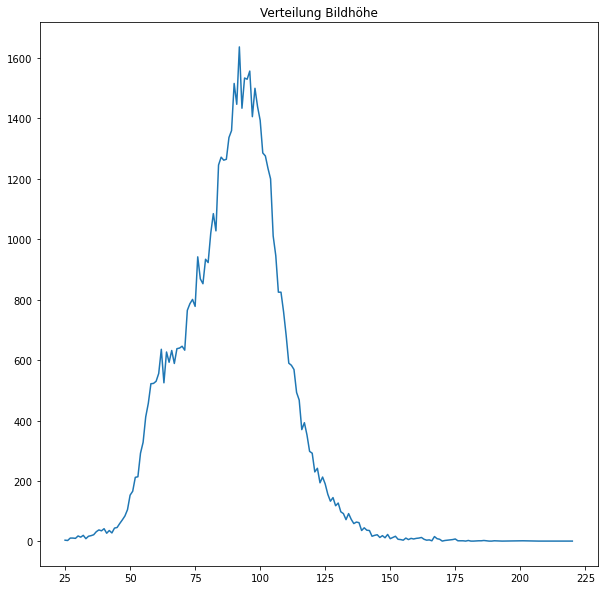

In [17]:
plt.figure(figsize=(10,10))
plt.title("Verteilung Bildhöhe")
plt.plot(unique_h,counts_h)

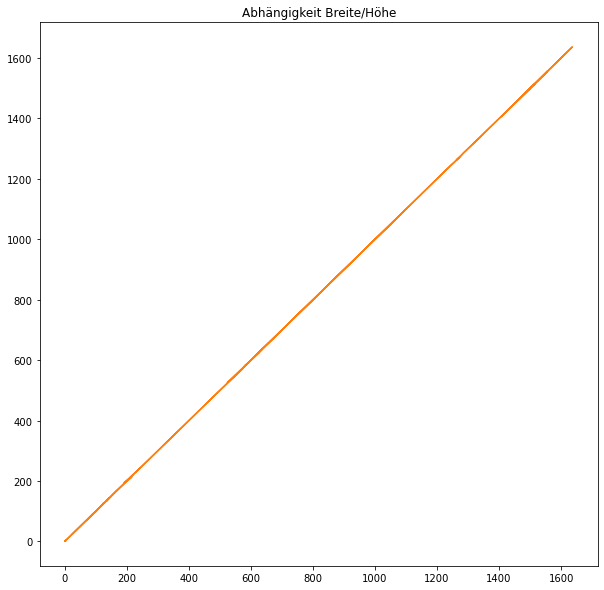

In [18]:
# Linearität der Seitenverhältnisse
plt.figure(figsize=(10,10))
plt.title("Abhängigkeit Breite/Höhe")
plt.plot(frequencies_w,frequencies_h)

In [19]:
batch_size = 128 #Wie viele Bilder in einem Batch

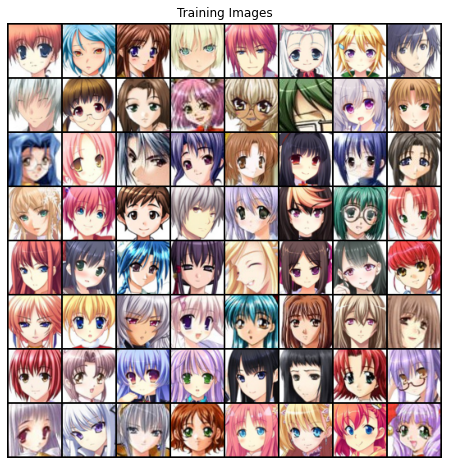

In [21]:
# Erstelle Dataloader aus bereinigtem Datensatz
# Zentriere Fotos und Resisze auf 64 px
dataset = dset.ImageFolder(root=dataroot_clean,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
                           )
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


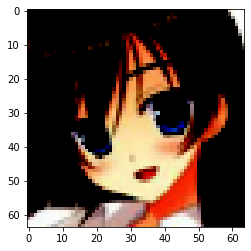

In [22]:

# Run this to test your data loader
images, labels = next(iter(dataloader))
# helper.imshow(images[0], normalize=False)
#valid_imshow_data(images[0])
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device)[:64], padding=2, normalize=False).cpu(),(1,2,0)))
